<a href="https://colab.research.google.com/github/Holsen-Gallegos/Ia-Fime/blob/main/Final_of_IA_PIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Mariana Seany Zamarripa Puente #2109690
* Zoe Daniela Vazquez Jurado #2023982
* Reynaldo Holsen Gallegos Gonzalez #1963727

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np # Import numpy
from pathlib import Path
import matplotlib.pyplot as plt # Import matplotlib.pyplot
import PIL
from PIL import UnidentifiedImageError
import pandas as pd
# System libraries
from pathlib import Path
import os.path

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten  # etc.
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Subir tu archivo kaggle.json desde tu cuenta
from google.colab import files
files.upload()  # <-- Aquí sube tu kaggle.json

# Crear la carpeta y copiar el archivo
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el dataset
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
!unzip -q augmented-alzheimer-mri-dataset.zip -d alzheimer_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 92% 349M/380M [00:00<00:00, 521MB/s]
100% 380M/380M [00:00<00:00, 524MB/s]


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

base_dir = r'./alzheimer_data/AugmentedAlzheimerDataset'

MildDemented_dir = os.path.join(base_dir, 'MildDemented')
ModerateDemented_dir = os.path.join(base_dir, 'ModerateDemented')
NonDemented_dir = os.path.join(base_dir, 'NonDemented')
VeryMildDemented_dir = os.path.join(base_dir, 'VeryMildDemented')


filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):

    if os.path.isdir(j):
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])
    else:
        print(f"Warning: Directory not found: {j}")


Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  ./alzheimer_data/AugmentedAlzheimerDataset/Mil...  Mild Demented
1  ./alzheimer_data/AugmentedAlzheimerDataset/Mil...  Mild Demented
2  ./alzheimer_data/AugmentedAlzheimerDataset/Mil...  Mild Demented
3  ./alzheimer_data/AugmentedAlzheimerDataset/Mil...  Mild Demented
4  ./alzheimer_data/AugmentedAlzheimerDataset/Mil...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [5]:
Alzheimer_df.shape

(33984, 2)

In [6]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [7]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


In [20]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [21]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [22]:
# @title Default title text
model = models.Sequential([
    layers.Input(shape=(244, 244, 3)),
    layers.Rescaling(1./255,),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 clases
])

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train,
    validation_data=val,
    steps_per_epoch=85,
    epochs=5,
)



Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 632s 7s/step - accuracy: 0.2804 - loss: 1.3862 - val_accuracy: 0.2763 - val_loss: 1.3814
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step - accuracy: 0.2645 - loss: 1.3809 - val_accuracy: 0.2763 - val_loss: 1.3800
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 625s 7s/step - accuracy: 0.2706 - loss: 1.3836 - val_accuracy: 0.2763 - val_loss: 1.3805
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 627s 7s/step - accuracy: 0.2931 - loss: 1.3761 - val_accuracy: 0.2763 - val_loss: 1.3784
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 614s 7s/step - accuracy: 0.2680 - loss: 1.3790 - val_accuracy: 0.2763 - val_loss: 1.3777


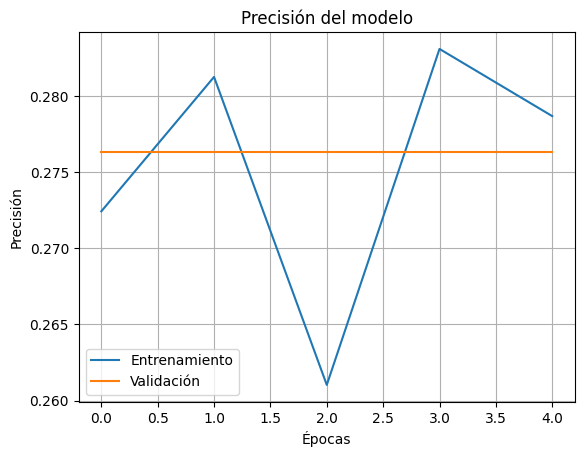

In [24]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()
plt.grid(True)
plt.show()


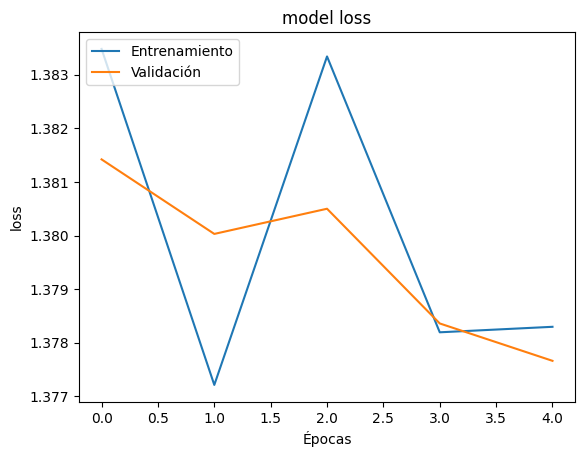

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [26]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step


In [27]:
test_labels = test_images['labels'].tolist()

In [28]:
#Ahora comparar los resultados con la clase verdadera
x = pred2[0] # Use pred2 which contains class names
y = test_labels[0]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Non Demented


In [29]:
x = pred2[5]
y = test_labels[5]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Very MildDemented


In [30]:
x = pred2[10]
y = test_labels[10]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Moderate Demented


In [31]:
x = pred2[20]
y = test_labels[20]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Mild Demented


In [32]:
x = pred2[80]
y = test_labels[80]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Non Demented


In [33]:
x = pred2[90]
y = test_labels[90]
print("La red dice que la imagen es clase " + x + " y la clase verdadera es: " + y)

La red dice que la imagen es clase Non Demented y la clase verdadera es: Mild Demented
